In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
from dataset import Dataset
from models import UNet
from trainer import Trainer
from utils import accuracy
from utils import save_predictions_as_imgs
from utils import hard_dice
from utils import DiceLoss
from utils import make_blending
from utils import BCEDiceLoss

In [7]:
train_folder = 'train'
batch_size = 1
device = 'cuda'

train_transforms = A.Compose(
    [
        A.Resize(height=512, width=512),
        #A.Rotate(limit=10, p=1),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.Blur(blur_limit=11, p=1),
        #A.ChannelShuffle(),
        #A.MedianBlur(blur_limit=1, p=1.0),
        #A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0, p=1),
        #A.ColorJitter(),
        # Это реальные среднее и дисперсия выборки, но такая нормализация не сильно помогает
        #tensor([0.8418, 0.8288, 0.8200]), tensor([0.2174, 0.2178, 0.2234]))
        #A.Normalize(mean=([0.8418, 0.8288, 0.8200]), std=([0.2174, 0.2178, 0.2234])),
        #A.Normalize(),
        ToTensorV2()
    ])

train_dataset = Dataset(train_folder, train_transforms)
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size, pin_memory=True, shuffle=True)

In [24]:
model = UNet(n_filters=32)
#criterion = nn.BCEWithLogitsLoss()
#criterion = DiceLoss()
criterion = BCEDiceLoss(0.8)
metric = {'name' : 'dice', 'func' : hard_dice}
config = {
    'lr': 1e-3,
    'epochs': 20,
    'early_stopping': 10
}
trainer = Trainer(model, criterion, metric, config)

In [25]:
trainer.fit(train_loader)

Epoch 1:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 0, loss: 0.4623272730545564,                   dice: 0.6385229710828174


Epoch 2:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 1, loss: 0.34949344261126086,                   dice: 0.7449583086100492


Epoch 3:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 2, loss: 0.32087498090483924,                   dice: 0.776772603392601


Epoch 4:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 3, loss: 0.3012190786274997,                   dice: 0.7886110788041895


Epoch 5:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 4, loss: 0.28099350224841724,                   dice: 0.7999015084721826


Epoch 6:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 5, loss: 0.2734130092642524,                   dice: 0.8033615174618635


Epoch 7:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 6, loss: 0.2559802295132117,                   dice: 0.8216893835501238


Epoch 8:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 7, loss: 0.25378197634761984,                   dice: 0.8190661208196119


Epoch 9:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 8, loss: 0.2539399794556878,                   dice: 0.8164193806323138


Epoch 10:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]

Epoch 9, loss: 0.2728533087806268,                   dice: 0.8039311021566391


Epoch 11:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]

Epoch 10, loss: 0.2435470081188462,                   dice: 0.8277678029103712


Epoch 12:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]

Epoch 11, loss: 0.22308284789323807,                   dice: 0.8482130386612632


Epoch 13:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]

Epoch 12, loss: 0.21839140592650932,                   dice: 0.8501054427840493


Epoch 14:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]

Epoch 13, loss: 0.20966901020570236,                   dice: 0.8555542122233998


Epoch 15:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]

Epoch 14, loss: 0.20455495132641358,                   dice: 0.8601362623951652


Epoch 16:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]

Epoch 15, loss: 0.1996679739518599,                   dice: 0.8656585108150135


Epoch 17:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]

Epoch 16, loss: 0.1993626400151036,                   dice: 0.8606912114403464


Epoch 18:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]

Epoch 17, loss: 0.19738693264397708,                   dice: 0.8627284223383124


Epoch 19:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]

Epoch 18, loss: 0.22009004652500153,                   dice: 0.8466472273523157


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████| 22/22 [00:11<00:00,  1.95it/s]

Epoch 19, loss: 0.2352663136341355,                   dice: 0.8362973169846968


In [539]:
save_predictions_as_imgs(train_loader, model)

In [10]:
model.load_state_dict(torch.load(os.path.join(Trainer.CHECKPOINTS_PATH, 'weights.pth')))
save_predictions_as_imgs(train_loader, model)

In [12]:
def show_images_with_mask(number, model_mask=False):
    img_path = './saved_images/orig_' + str(number) + '.png'
    mask_path = ''
    if model_mask == False:
        mask_path = './saved_images/' + str(number) + '.png'
    else:
        mask_path = './saved_images/pred_' + str(number) + '.png'
    plt.figure(figsize=(7, 7))
    blend = make_blending(img_path, mask_path)
    plt.axis('off')
    plt.imshow(blend)

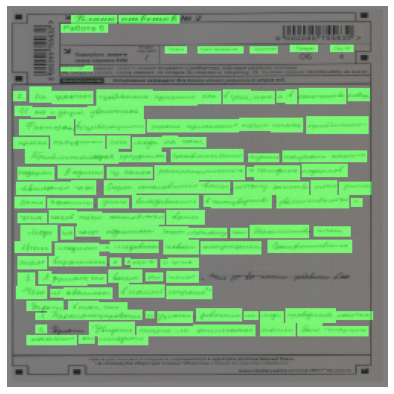

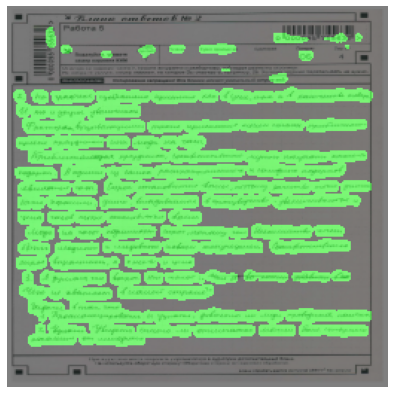

In [23]:
show_images_with_mask(4, False)
show_images_with_mask(4, True)